In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import anndata as ad
import scanpy as sc
import sys
sys.path.append("../../spatial-clust-scripts-main/")
import utils
import os
from tqdm import tqdm
import torch
from skimage.io import imread
from scipy.io import loadmat
from skimage.measure import regionprops
from skimage.transform import resize
import skimage
# import custom functions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re
import graph
import seaborn as sns
from skimage.filters import threshold_otsu


### read in meta file

In [2]:
df = pd.read_csv('../data/livcan_meta_y4_x69.csv')
df.fov = df.fov.astype(str)
df.head()

,RNA_pca_cluster_default,RNA_pca_cluster_default.1,orig.ident,nCount_RNA,nFeature_RNA,nCount_negprobes,nFeature_negprobes,nCount_falsecode,nFeature_falsecode,fov,...,nCount,nCountPerCell,nFeaturePerCell,propNegativeCellAvg,complexityCellAvg,errorCtPerCellEstimate,percOfDataFromErrorPerCell,qcFlagsFOV,cellType,niche
0,5,8,c,2974,453,0,0,2,2,305,...,1276579,1047.234619,217.455291,0.000644,3.677354,56.111567,0.053581,Pass,tumor_2,tumor subtype
1,14,2,c,4406,463,1,1,4,4,307,...,1451940,1269.178322,235.490385,0.000674,4.149606,70.192308,0.055305,Pass,tumor_1,tumor
2,14,2,c,6162,537,2,2,4,4,307,...,1451940,1269.178322,235.490385,0.000674,4.149606,70.192308,0.055305,Pass,tumor_1,tumor
3,19,19,c,515,262,1,1,16,16,307,...,1451940,1269.178322,235.490385,0.000674,4.149606,70.192308,0.055305,Pass,CD3+.alpha.beta.T.cells,tumor
4,2,6,c,2382,353,2,2,8,8,307,...,1451940,1269.178322,235.490385,0.000674,4.149606,70.192308,0.055305,Pass,tumor_1,tumor


Custom code to tile individual FOVs back to the tissue tile

This was done manually by identifing each FOV's relative location etc.

In [36]:
## first make a dictionary for unregular fov locations

dd = {'305':[1,1], '306':[1,2], '307':[1,3], '308':[1,4], '309':[1,5], '310':[1,6], '311':[1,7],
     '322':[2,1], '323':[2,2], '324':[2,3], '325':[2,4], '326':[2,5], '327':[2,6], '328':[2,7],
     '337':[3,1], '338':[3,2], '339':[3,3], '340':[3,4], '341':[3,5], '342':[3,6], '343':[3,7],
     '346':[4,1], '347':[4,2], '348':[4,3], '349':[4,4], '350':[4,5], '351':[4,6], '352':[4,7],
                  '355':[5,2], '356':[5,3], '357':[5,4], '358':[5,5], '359':[5,6], '360':[5,7],
     '363':[6,1], '364':[6,2], '365':[6,3], '366':[6,4], '367':[6,5], '368':[6,6], '369':[6,7],
     '371':[7,1], '372':[7,2], '373':[7,3], '374':[7,4], '375':[7,5], '376':[7,6], 
                 '377':[8,2], '378':[8,3], '379':[8,4], '380':[8,5],
                 '381':[9,2], '382':[9,3], '383':[9,4]}

root_dir = '/mnt/cloud1/sheng-projects/st_projects/spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/Liver_smi/data/LiverCancerFiles/CellStatsDir/Morpohology2D/'
name_format = '20221008_005902_S3_C902_P99_N99_F'
#20221008_005902_S3_C902_P99_N99_F001.TIF

### parameters
shape_of_each_view = [4256, 4256]
shape_of_views = [9, 7]
pad = 500
fovlist = np.unique(df.fov)
#size = 100
###

#### tile the image
pad_image = np.zeros((shape_of_each_view[0]*shape_of_views[0], 
                          shape_of_each_view[1]*shape_of_views[1], 5))

for fov in fovlist:
    fovid = "%03d" % (int(fov),)
    view = dd[fov]
    view_i = view[0]-1
    view_j = view[1]-1
    
    img_dir = root_dir + name_format + fovid + '.TIF'
    img = np.transpose(imread(img_dir), (1,2,0))
    
    pad_image[view_i*shape_of_each_view[0]:(view_i+1)*shape_of_each_view[0],
                view_j*shape_of_each_view[1]:(view_j+1)*shape_of_each_view[1],:] = img

print('tiling finished')

##### tissue tiling finished, pad it
zero_pad_entire_view = np.zeros((pad_image.shape[0]+2*pad, pad_image.shape[1]+2*pad, pad_image.shape[2]))
zero_pad_entire_view[pad:pad_image.shape[0]+pad, pad:pad_image.shape[1]+pad, :] = pad_image

tiling finished


In [37]:
# truncate
truncate = np.quantile(pad_image, q = 0.9, axis = (0, 1))
zero_pad_entire_view[zero_pad_entire_view <= truncate] = 0
zero_pad_entire_view[zero_pad_entire_view > truncate] = 1

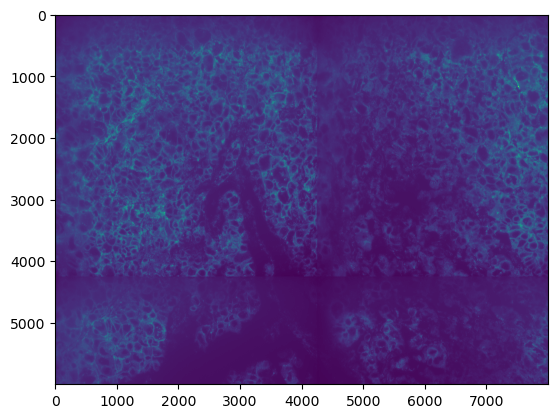

In [38]:
plt.imshow(pad_image[:6000,:8000,2])

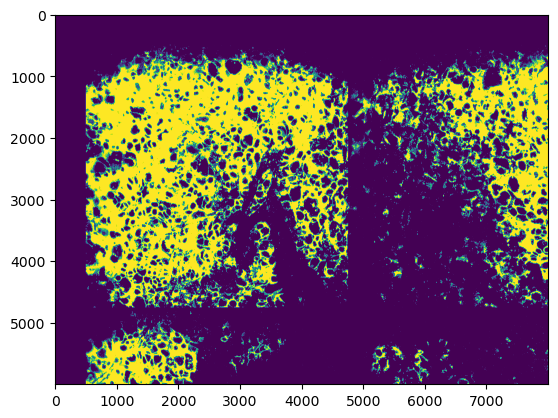

In [39]:
plt.imshow(zero_pad_entire_view[:6000,:8000,2])

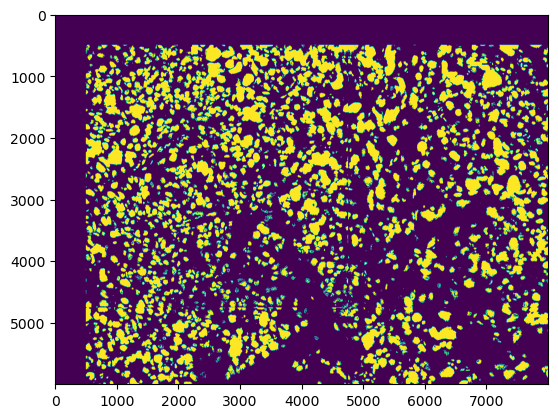

In [40]:
plt.imshow(zero_pad_entire_view[:6000,:8000,4])

### Generate cropped morphology images for each cell


  0%|                                                                                         | 0/54867 [00:00<?, ?it/s]

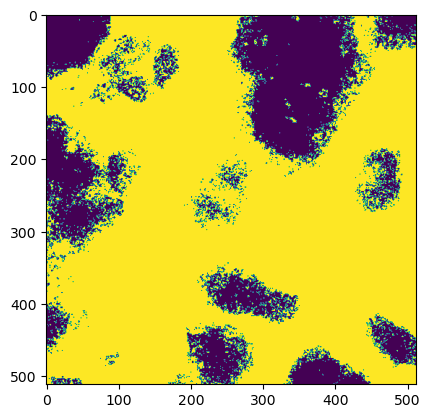

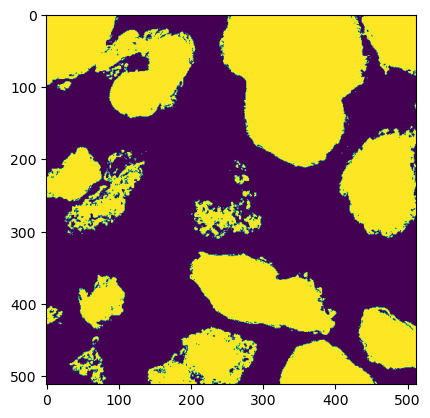

  9%|███████                                                                      | 4988/54867 [00:07<01:16, 647.79it/s]

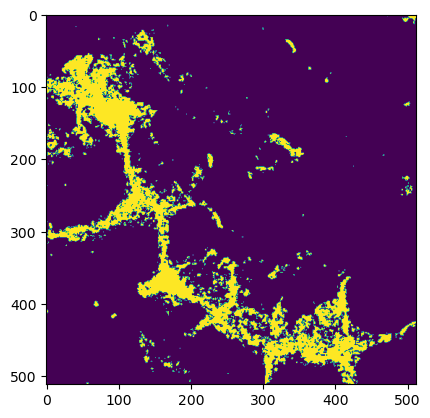

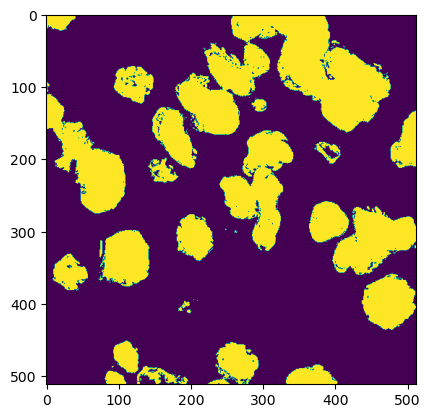

 18%|█████████████▉                                                               | 9959/54867 [00:15<01:08, 656.34it/s]

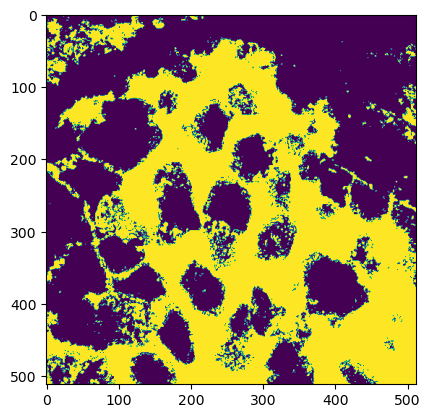

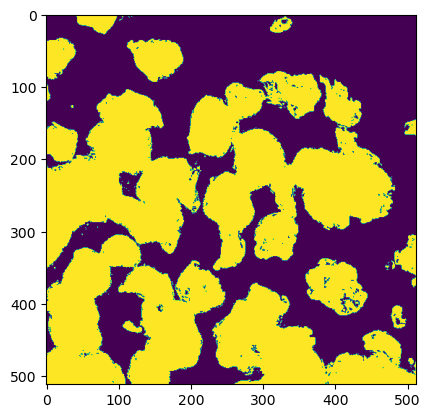

 27%|████████████████████▋                                                       | 14942/54867 [00:23<01:00, 662.06it/s]

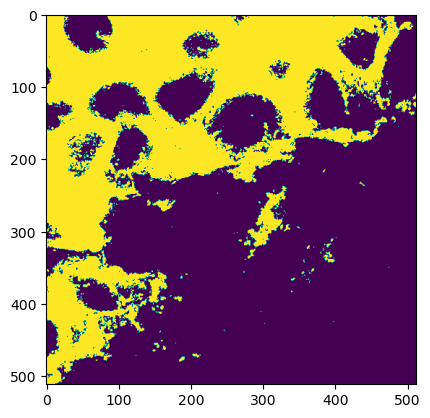

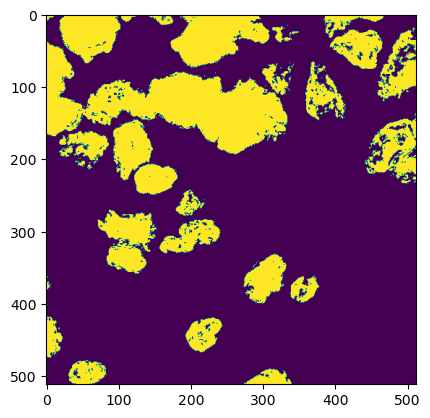

 36%|███████████████████████████▋                                                | 19990/54867 [00:31<00:54, 644.10it/s]

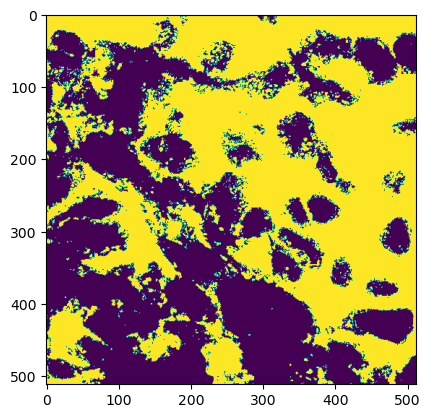

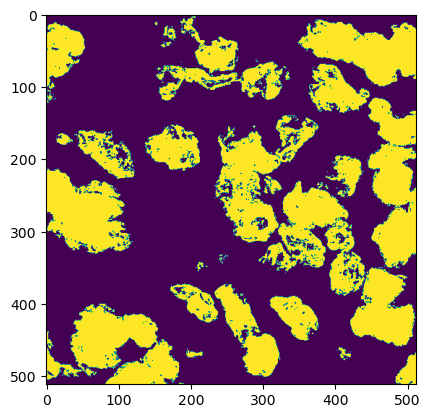

 45%|██████████████████████████████████▌                                         | 24945/54867 [00:38<00:43, 692.72it/s]

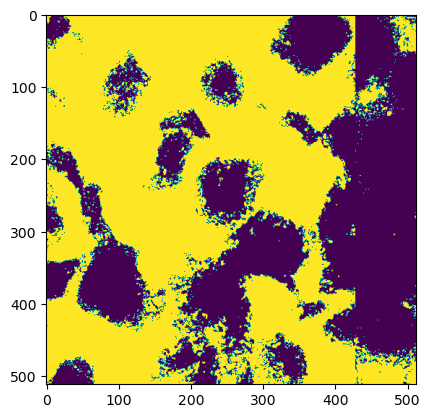

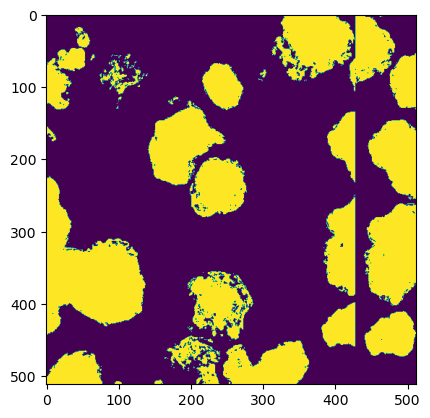

 55%|█████████████████████████████████████████▌                                  | 29998/54867 [00:46<00:36, 680.16it/s]

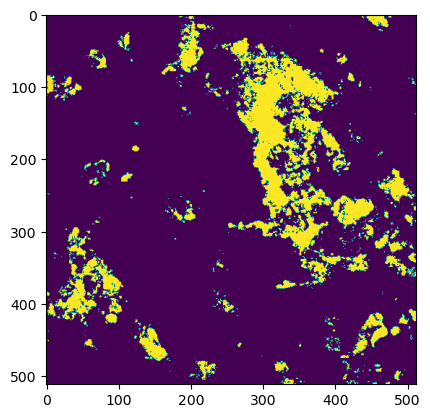

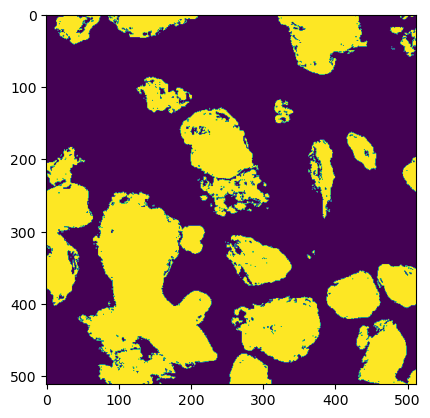

 64%|████████████████████████████████████████████████▍                           | 34988/54867 [00:53<00:28, 703.25it/s]

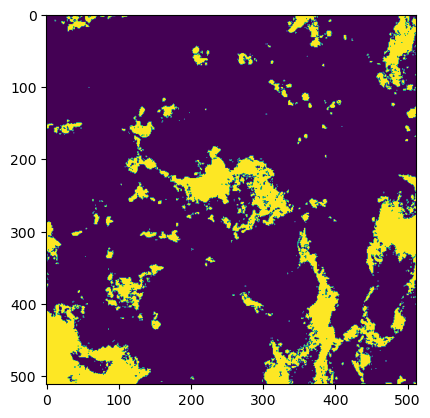

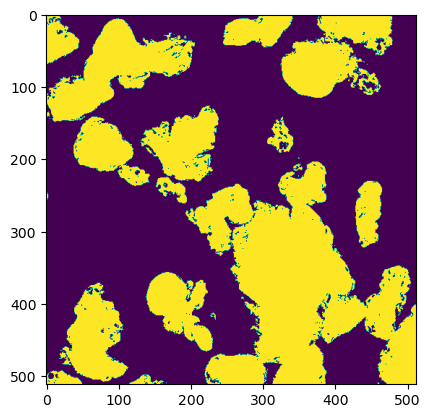

 73%|███████████████████████████████████████████████████████▎                    | 39964/54867 [01:00<00:21, 689.23it/s]

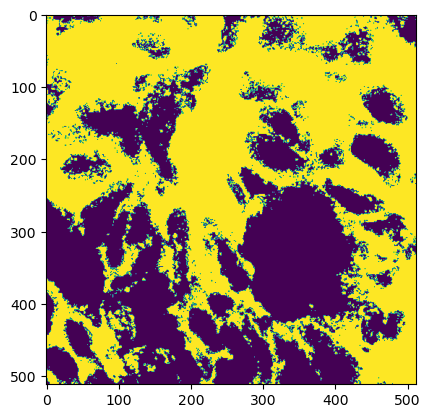

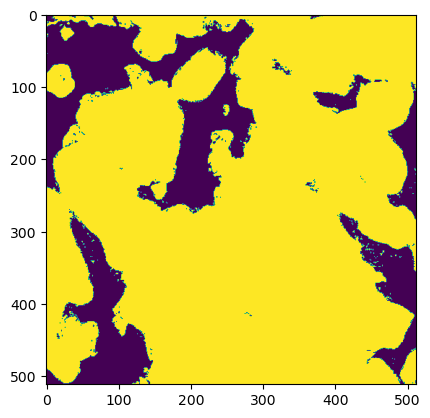

 82%|██████████████████████████████████████████████████████████████▎             | 44988/54867 [01:08<00:14, 682.31it/s]

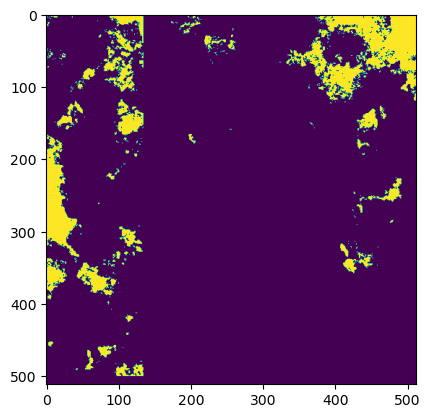

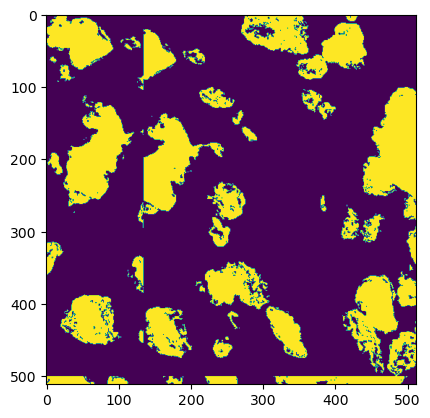

 91%|█████████████████████████████████████████████████████████████████████▏      | 49940/54867 [01:15<00:07, 691.77it/s]

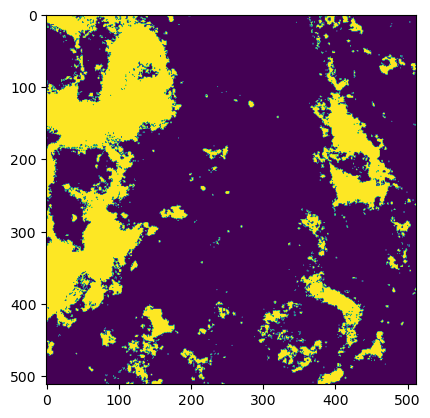

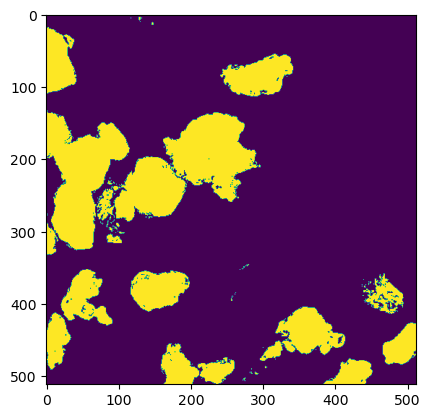

100%|████████████████████████████████████████████████████████████████████████████| 54867/54867 [01:22<00:00, 665.38it/s]


In [41]:
save_folder = '../data/single_cell_images/HCC_4_69/'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
size = 512

### each cell
n_cell = df.shape[0]
img_idx = 0

for i in tqdm(range(n_cell)):
    # process each cell
    center_x = df.iloc[i]["y_FOV_px"]
    center_y = df.iloc[i]["x_FOV_px"]
    
    # fov loc
    fov_cell = df.iloc[i]["fov"]
    view = dd[fov_cell]
    view_i = view[0]-1
    view_j = view[1]-1
    
    ## correct
    center_x = center_x + shape_of_each_view[0]*view_i
    center_y = center_y + shape_of_each_view[1]*view_j
    
    #
    cur_image = np.transpose(zero_pad_entire_view[(int(center_x)-size//2+pad):(int(center_x)+size//2+pad), 
                                               (int(center_y)-size//2+pad):(int(center_y)+size//2+pad), 
                                               [2,4]], (2, 0, 1)).astype(np.int8) # mem - nuclear
    assert(cur_image.shape == (2, size, size))
    
    np.save(file = os.path.join(save_folder, f"img_{img_idx:06d}"), arr = cur_image)
    if i % 5000 == 1:
        plt.imshow(cur_image[0, :, :])
        plt.show()
        plt.imshow(cur_image[1, :, :])
        plt.show()
    img_idx += 1

## next step prep other info

In [3]:
df_count = pd.read_csv('../data/livcan_counts_y4_x69.csv')
df_count.head()

,AATK,ABL1,ABL2,ACACB,ACE,ACKR1,ACKR3,ACKR4,ACP5,ACTA2,...,WNT7A,WNT7B,WNT9A,XBP1,XCL1,XKR4,YBX3,YES1,ZBTB16,ZFP36
0,0.873008,-0.899111,-0.761059,-1.339173,0.568835,-0.555687,-0.683929,0.784943,0.059660,-0.857468,...,-0.467617,-0.686448,0.917134,-2.003820,1.273756,-0.395283,2.138706,0.332135,-1.831427,0.737800
1,-0.793585,-0.187628,-0.925050,0.176717,-0.914694,-0.675865,-0.831523,-0.826315,-1.173083,-1.041842,...,-0.568871,0.355286,0.499942,-1.246374,0.685614,-0.480947,-0.652747,0.903774,-0.998982,-1.820885
2,0.120180,-0.525507,-1.092105,-0.900105,-1.079920,-0.798552,-0.982008,-0.975875,0.743403,-1.229429,...,-0.672314,-0.985607,-0.918791,2.063357,0.207202,-0.568507,2.132701,-0.396364,-2.302735,1.978299
3,3.400688,-0.375407,-0.317463,-0.561453,-0.313883,-0.231536,-0.285158,-0.283361,2.070635,-0.357911,...,-0.194767,-0.286212,-0.266653,-0.848054,-0.379477,-0.164597,-0.805350,-0.352301,-0.957774,0.481391
4,-0.584347,0.428393,-0.681505,0.441121,0.803433,-0.497467,-0.612370,-0.608522,-0.865276,-0.767956,...,-0.418586,-0.614627,1.167544,-1.263150,-0.813996,-0.353815,2.256925,-0.755973,-1.553186,-0.504792


In [4]:
adata = ad.AnnData(
    df_count, dtype=np.float32
)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
#sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
#sc.tl.umap(adata)
adata.obsm['X_pca'].shape

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


(54867, 50)

In [7]:
pc = adata.obsm['X_pca']
np.save('../data/469_pc.npy', pc)

In [47]:
data_dir = '../data/'


features = adata.obsm['X_pca'][:,:30] # top 20 PC for harmony #.to_numpy()
#features = utils.center_scale(features)

res = 0.5
knn = 20

feature_edges = graph.get_feature_edges(
    arr=features, pca_components=None, # no repeat PCA in this case
    n_neighbors=15, metric='correlation', verbose=False
)

feature_labels = graph.graph_clustering(
    features.shape[0], feature_edges, resolution=res, n_clusters=None, n_runs=1,
    resolution_tol=0.05, seed=None, verbose=False
)

np.save(os.path.join(data_dir, f'469_feature_labels_res{res}.npy'), feature_labels)
np.save(os.path.join(data_dir, f'469_feature_edges_res{res}.npy'), np.array(feature_edges[:2]).T)

print('Calculating cell neighborhood composition matrix...')
locations = df[['x_slide_mm', 'y_slide_mm']].to_numpy()
spatial_knn_indices = graph.get_spatial_knn_indices(locations=locations, n_neighbors=knn, method='kd_tree')
cell_nbhd = utils.get_neighborhood_composition(knn_indices=spatial_knn_indices, labels=feature_labels)
np.save(os.path.join(data_dir, f'469_cell_nbhd_res{res}_k{knn}.npy'), cell_nbhd)

## save out spatial edge, always 15 cells
locations = df[['x_slide_mm', 'y_slide_mm']].to_numpy()
spatial_edges = graph.get_spatial_edges(
    arr=locations, n_neighbors=15, verbose=True
)
np.save(os.path.join(data_dir, f'spatial_edges_0325.npy'), np.array(spatial_edges[:2]).T)


Calculating cell neighborhood composition matrix...


In [48]:
print([feature_labels.shape, cell_nbhd.shape])

[(54867,), (54867, 11)]


/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


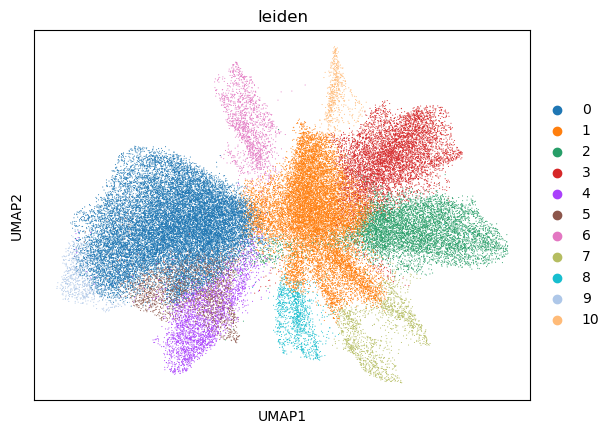

In [44]:
## check
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=['leiden'])

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


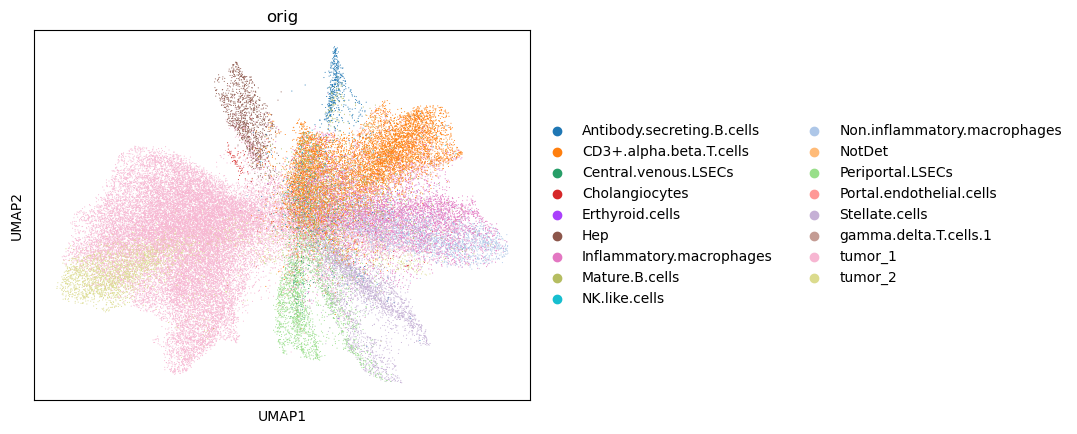

In [46]:
adata.obs['orig'] = df.cellType.values#()
sc.pl.umap(adata, color=['orig'])

### concact

In [14]:
feat = np.load('../data/469_pc.npy')
nbhd = np.load('../data/469_cell_nbhd_res0.5_k20.npy')
concat = np.concatenate((feat[:,:30], nbhd), axis = 1)#.shape
np.save('../data/469_concact.npy', concat)
print([concat.shape, nbhd.shape])

[(54867, 41), (54867, 11)]
